In [ ]:
!pip install fuzzywuzzy

In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from rapidfuzz import fuzz, process

sns.set()

# Data understanding

## Reading the data

In [408]:
cars_test = pd.read_csv("test.csv")
cars_test_copy = cars_test.copy()

cars_test.head(5)

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
1,106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
2,80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
3,100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
4,81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0


## Meta data

| **Attribute**       | **Description** |
|----------------------|-----------------|
| **carID**            | An attribute that contains an identifier for each car. |
| **Brand**            | The car’s main brand (e.g. Ford, Toyota). |
| **model**            | The car model. |
| **year**             | The year of registration of the car. |
| **mileage**          | The total reported distance travelled by the car (in miles). |
| **tax**              | The amount of road tax (in £) that, in 2020, was applicable to the car in question. |
| **fuelType**         | Type of fuel used by the car (Diesel, Petrol, Hybrid, Electric). |
| **mpg**              | Average miles per gallon. |
| **engineSize**       | Size of engine in liters (cubic decimeters). |
| **paintQuality%**    | The mechanic’s assessment of the car’s overall paint quality and hull integrity (filled by the mechanic during evaluation). |
| **previousOwners**   | Number of previous registered owners of the vehicle. |
| **hasDamage**        | Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not. |
| **price**            | The car’s price when purchased by Cars 4 You (in £). |


### Initial Analysis
General idea of the data structure, column names and types of values each variable contains.

In [409]:
cars_test.duplicated("carID").sum()

0

No carId duplicated, so we can put as index.

In [410]:
cars_test.set_index("carID", inplace=True)

In [411]:
cars_test.head()

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0


In [412]:
cars_test.shape

(32567, 12)

In [413]:
cars_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32567 entries, 89856 to 99627
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           31918 non-null  object 
 1   model           31917 non-null  object 
 2   year            31914 non-null  float64
 3   transmission    31944 non-null  object 
 4   mileage         31878 non-null  float64
 5   fuelType        31911 non-null  object 
 6   tax             29259 non-null  float64
 7   mpg             29279 non-null  float64
 8   engineSize      31939 non-null  float64
 9   paintQuality%   31942 non-null  float64
 10  previousOwners  31970 non-null  float64
 11  hasDamage       31970 non-null  float64
dtypes: float64(8), object(4)
memory usage: 3.2+ MB


In [414]:
cars_test.columns

Index(['Brand', 'model', 'year', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage'],
      dtype='object')

## Metric vs non metric features

In [415]:
metric_features = ['year', 'mileage','tax','mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
non_metric_features = cars_test.columns.drop(metric_features).to_list()

## Data Quality check

### Strange Values

#### Metric features

In [416]:
cars_test.describe().T

,count,mean,std,min,25%,50%,75%,max
year,31914.0,2017.102299,2.207969,1991.000000,2016.00,2017.0,2019.0,2024.121759
mileage,31878.0,22952.658921,22132.758713,-58540.574478,7298.25,17225.5,32500.0,279000.000000
tax,29259.0,120.569239,65.560570,-91.121630,125.00,145.0,145.0,580.000000
mpg,29279.0,55.210728,17.644635,-43.421768,46.30,54.3,62.8,470.800000
engineSize,31939.0,1.665377,0.574467,-0.103493,1.20,1.6,2.0,6.600000
paintQuality%,31942.0,64.446667,21.142188,1.638913,47.00,65.0,82.0,125.594308
previousOwners,31970.0,2.006118,1.472310,-2.345650,1.00,2.0,3.0,6.258371
hasDamage,31970.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000


### Here we can detect many strange values as:
    2024.121759 in the year column;
    -58540.574478 in the mileage column;
    -91.121630 in the tax column;
    -43.421768 in the mpg column;
    -0.103493 in the engineSize column;
    125.594308 in the paintQuality% column;
    -2.345650 in the previousOwners column;
    just zeros in the hasDamage column.

##### year

In [417]:
cars_test["year"]=[int(i) if isinstance(i, float) and not pd.isna(i) else i for i in cars_test["year"]]
cars_test["year"] = cars_test["year"].astype("Int64")
cars_test.year

carID
89856     2022
106581    2017
80886     2016
100174    2019
81376     2019
          ... 
105775    2017
81363     2020
76833     2019
91768     2019
99627     2017
Name: year, Length: 32567, dtype: Int64

##### mileage

In [418]:
def negatives_to_nan(column,limit):

    strange_values = cars_test[column] < limit
    print(f"Found {strange_values.sum()} negative values in {column}.")
    cars_test.loc[strange_values, column] = np.nan 
    return cars_test[column].min()


In [419]:
negatives_to_nan("mileage",0)


Found 170 negative values in mileage.


1.0

##### tax

In [420]:
negatives_to_nan("tax",0)

Found 161 negative values in tax.


0.0

##### mpg

In [421]:
negatives_to_nan("mpg",10)

Found 74 negative values in mpg.


11.0

##### engineSize

In [422]:
negatives_to_nan("engineSize",1)

Found 245 negative values in engineSize.


1.0

##### paintQuality%

In [423]:
strange_values_tax = cars_test["paintQuality%"] > 100
cars_test.loc[strange_values_tax, "paintQuality%"] = np.nan 
cars_test["paintQuality%"].max()

99.0

##### previousOwners

In [424]:
negatives_to_nan("previousOwners",0)
cars_test["previousOwners"]=[int(i) if isinstance(i, float) and not pd.isna(i) else i for i in cars_test["previousOwners"]]
cars_test["previousOwners"] = cars_test["previousOwners"].astype("Int64")
cars_test.previousOwners

Found 168 negative values in previousOwners.


carID
89856     3
106581    2
80886     2
100174    1
81376     4
         ..
105775    1
81363     3
76833     4
91768     1
99627     4
Name: previousOwners, Length: 32567, dtype: Int64

##### hasDamage

In [425]:
cars_test.hasDamage.value_counts()

hasDamage
0.0    31970
Name: count, dtype: int64

By looking at this result, we can conclude that the stand only sells cars that have no damage at all. So we can drop this column

In [426]:
del cars_test["hasDamage"]
metric_features.remove("hasDamage")
cars_test.head(1)

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,,,,
89856,Hyundai,I30,2022,Automatic,30700.0,petrol,205.0,41.5,1.6,61.0,3


### Non metric Features

# edu faz o codigo para "limpar" as colunas

In [427]:
def build_valid_dic(column, valid_list, cuttoff):
    #first, clean de column and the valid list
    unique_column_values = [str(v).strip().lower() for v in column.dropna().unique()] 
    #secound, creat the dic with the valid values with empyt similar words
    result = {valid_word: [] for valid_word in valid_list}

    for valid in valid_list:
        valid_lower = valid.lower()
        fuzzy_matched_values = process.extract(
            valid_lower, #the check valeu
            unique_column_values, #the list that we are going to use to check
            scorer = fuzz.token_sort_ratio,
            score_cutoff = cuttoff
        )
        for match in fuzzy_matched_values:
            match_value = unique_column_values[match[2]]
            if match_value.lower() != valid_lower:
                result[valid].append(match_value)
            
    return result


def replace_invalid_values(column, valid_dic):
    corrected = []
    for val in column:
        if pd.isna(val):
            corrected.append(val)
            continue
        valeu_cleaned = str(val).strip().lower()
        found = False
        for key in valid_dic:
            if valeu_cleaned == key.lower():
                corrected.append(key)
                found = True
                break
        if not found:
            for valid_key, variations in valid_dic.items():
                if valeu_cleaned in [v.lower() for v in variations]:
                    corrected.append(valid_key)
                    found = True
                    break
        if not found:
            corrected.append(val)
                
    return corrected

In [428]:
valid_brands_list = ["Ford", "Mercedes", "VW", "Opel", "BMW", "Audi", "Toyota","Skoda", "Hyundai"]
valid_transmition_list = ["Manual", "Semi-Auto", "Automatic", "Other", "Unknown"]
valid_fueltype_list = ["Petrol" ,"Diesel", "Hybrid" , "Other", "Electric"]
cols_change_dic = {"Brand" : valid_brands_list, 
                      "transmission" : valid_transmition_list, 
                      "fuelType" : valid_fueltype_list
                      }

In [429]:

for i in range(1,3):
    for key,values in cols_change_dic.items():
        valid_dic = build_valid_dic(cars_test[key],values, cuttoff= 10)
        cars_test[key] = replace_invalid_values(cars_test[key], valid_dic)
        if i == 2:
            print(cars_test[key].value_counts())


Brand
Ford        6892
Mercedes    5008
VW          4466
Opel        4008
BMW         3172
Audi        3127
Toyota      1982
Skoda       1836
Hyundai     1427
Name: count, dtype: int64
transmission
Manual       17880
Semi-Auto     7267
Automatic     6446
Unknown        345
Other            6
Name: count, dtype: int64
fuelType
Petrol      17492
Diesel      13391
Hybrid        936
Other          91
Electric        1
Name: count, dtype: int64


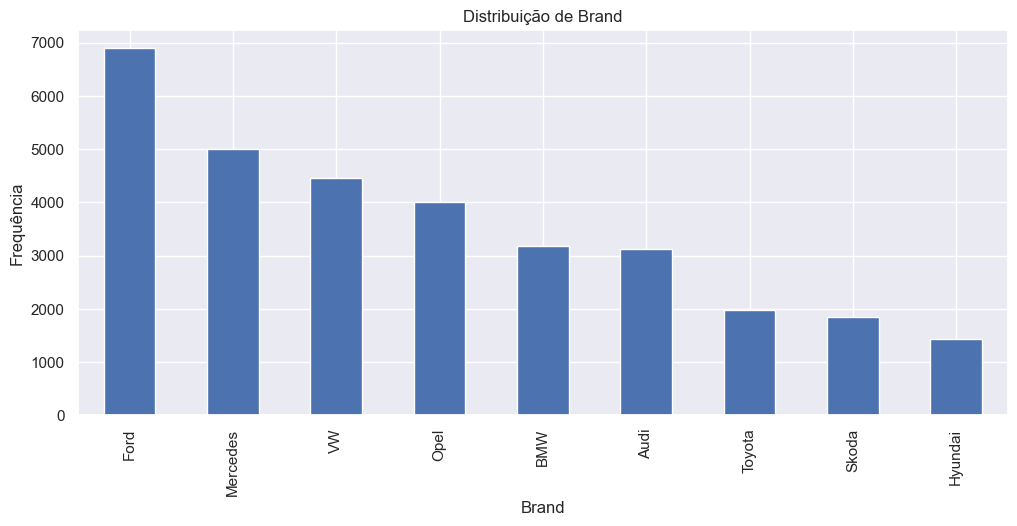

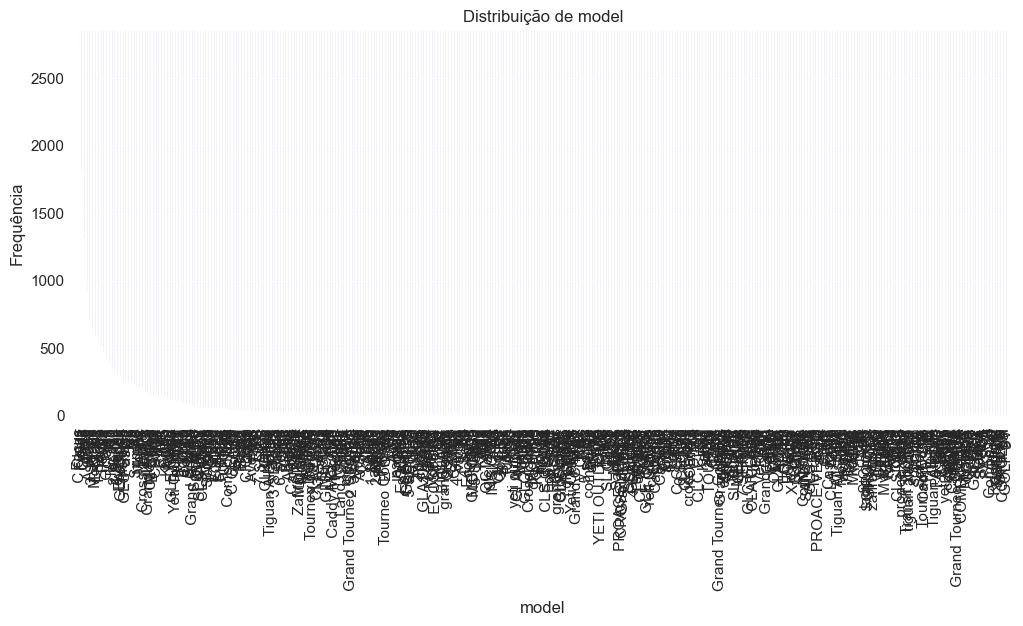

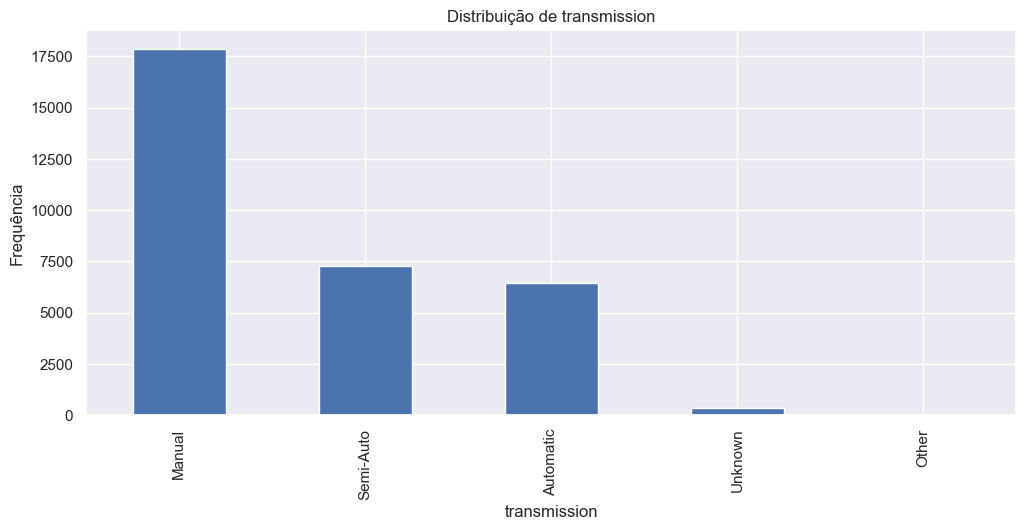

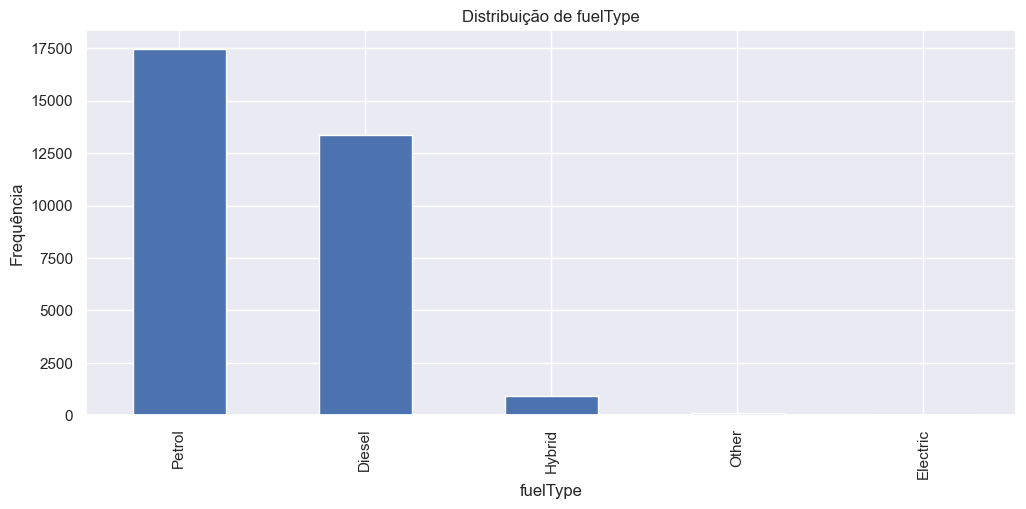

In [448]:
for col in non_metric_features:
    plt.figure(figsize=(12, 5))
    cars_test[col].value_counts().plot(kind="bar")
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Frequência")
    plt.show()

## Missing Values

In [431]:
print(cars_test.isna().sum())

Brand              649
model              650
year               653
transmission       623
mileage            859
fuelType           656
tax               3469
mpg               3362
engineSize         873
paintQuality%      793
previousOwners     765
dtype: int64


### Numerical features

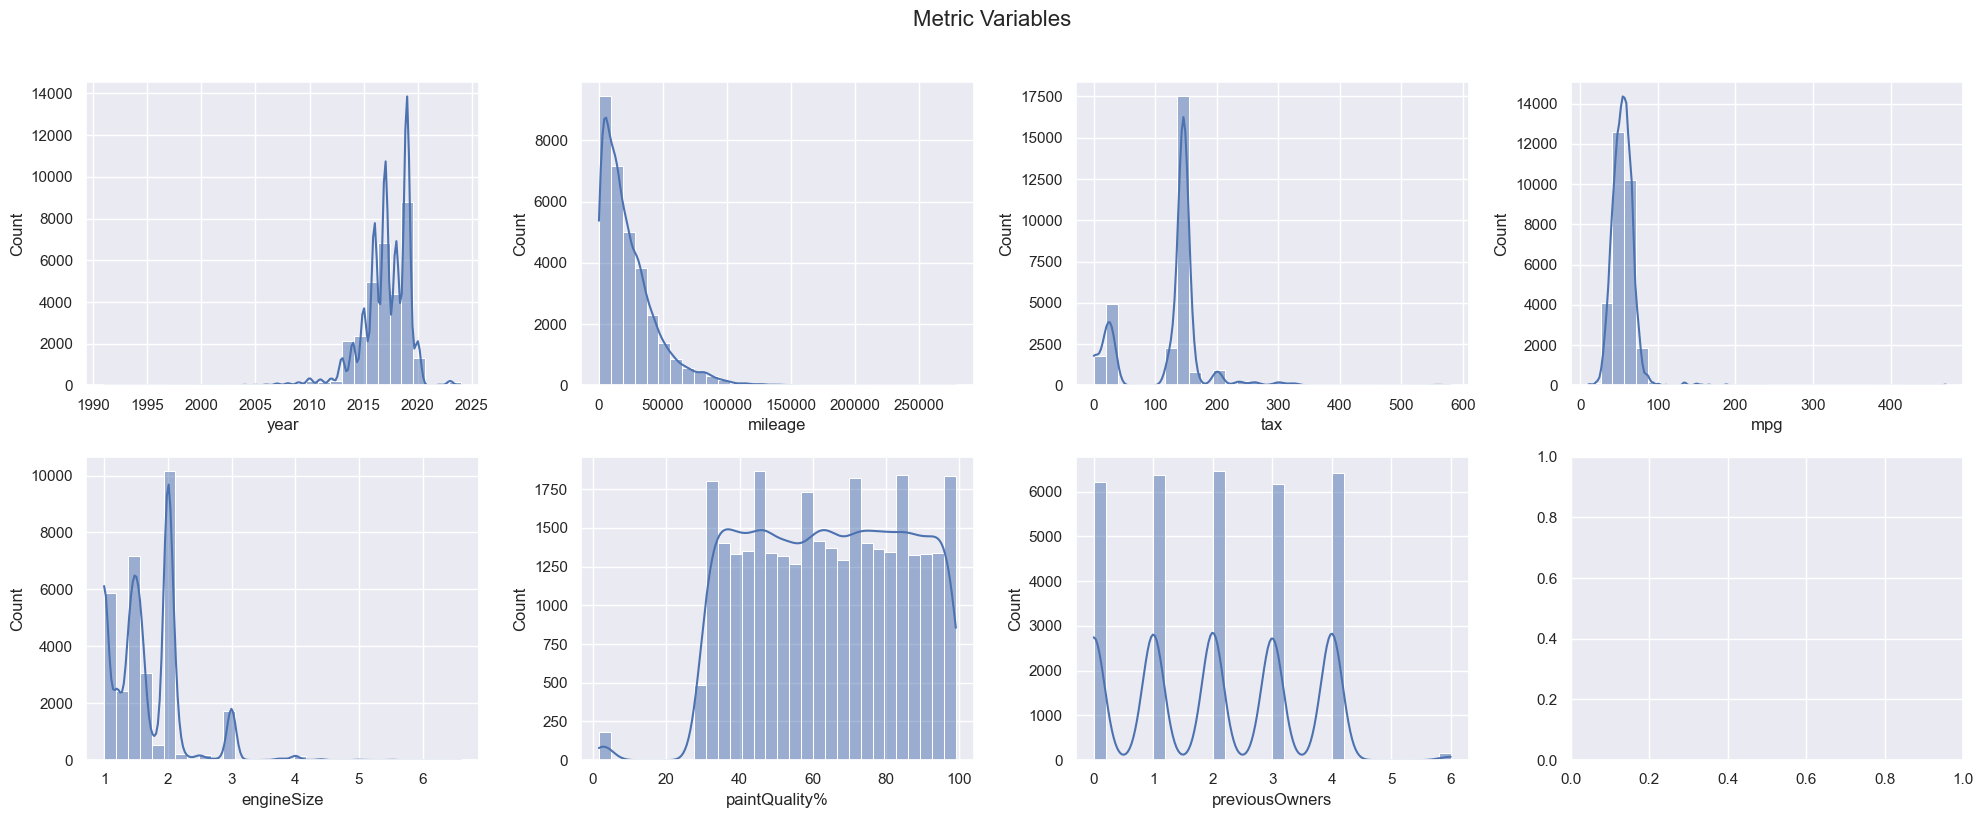

In [432]:
sp_rows = 2
sp_cols = 4

# Prepare figure and axes
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 8), tight_layout=True)

# Plot data with seaborn
features = [f for f in metric_features]

for ax, feat in zip(axes.flatten(), features):
    sns.histplot(cars_test[feat], bins=30, kde=True, ax=ax)

# Add a centered title to the figure
title = "Metric Variables"
fig.suptitle(title, fontsize=16, y=1.02)

plt.show()



##### year

In [433]:
def mean_median(column):
    mean = cars_test[column].mean()
    median = cars_test[column].median()
    print(f"mean: {mean} ; median: {median}")

In [434]:
mean_median("year")

mean: 2017.0970420505107 ; median: 2017.0


In [435]:
cars_test["year"] = cars_test["year"].fillna(2017)


we changed the nans by the median value because ....

##### mileage

In [436]:
mean_median("mileage")

mean: 23327.676219092253 ; median: 17363.0


In [437]:
cars_test["mileage"] = cars_test["mileage"].fillna(17363)

we changed the nans by the median value because ....

##### tax

In [438]:
mean_median("tax")

mean: 121.49627705172632 ; median: 145.0


In [439]:
cars_test["tax"] = cars_test["tax"].fillna(145)

we changed the nans by the median value because ....

##### mpg

In [440]:
mean_median("mpg")

mean: 55.35887253999213 ; median: 54.3


In [441]:
cars_test["mpg"] = cars_test["mpg"].fillna(54.3)

we changed the nans by the median value because ....

##### engineSize

In [442]:
mean_median("engineSize")

mean: 1.6771759294329782 ; median: 1.6


In [443]:
cars_test["engineSize"] = cars_test["engineSize"].fillna(1.6)

we changed the nans by the median value because ....

##### paintQuality%

In [444]:
mean_median("paintQuality%")

mean: 64.12504601156323 ; median: 64.0


In [445]:
cars_test["paintQuality%"] = cars_test["paintQuality%"].fillna(64)

we changed the nans by the median value because ....

##### previousOwners

In [446]:
mean_median("previousOwners")

mean: 2.02770266021005 ; median: 2.0


In [447]:
cars_test["previousOwners"] = cars_test["previousOwners"].fillna(2)

we changed the nans by the median value because ....

### Non metric features

# edu faz o codigo para preencher as colunas 